<a href="https://colab.research.google.com/github/rasaghnak/EDA_On_E_Com_Marketing/blob/main/RK_E_Commerce_Marketing_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import zipfile
import os

zip_file = "/content/archive (3).zip"
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall("/content/")

extracted_files = os.listdir("/content/")
print(extracted_files)


['.config', 'ORDER_REVIEW_RATINGS.csv', 'SELLERS.csv', 'ORDER_ITEMS.csv', 'GEO_LOCATION.csv', 'archive (3).zip', 'CUSTOMERS.csv', 'PRODUCTS.csv', 'ORDERS.csv', 'ORDER_PAYMENTS.csv', 'sample_data']


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

Total Revenue: 14274961.23
Total Quantity: 141571.0
Total Products: 32951
Total Categories: 71
Total Sellers: 3095
Total Locations: 4119
Total Channels: 5
Total Payment Methods: 5
      Month  New Customers
0   2016-09              4
1   2016-10            324
2   2016-12              1
3   2017-01            800
4   2017-02           1780
5   2017-03           2682
6   2017-04           2404
7   2017-05           3700
8   2017-06           3245
9   2017-07           4026
10  2017-08           4331
11  2017-09           4285
12  2017-10           4631
13  2017-11           7544
14  2017-12           5673
15  2018-01           7269
16  2018-02           6728
17  2018-03           7211
18  2018-04           6939
19  2018-05           6873
20  2018-06           6167
21  2018-07           6292
22  2018-08           6512
23  2018-09             16
24  2018-10              4
      Month  Acquired Customers  Retained Customers  Retention Rate
0   2016-09                   4                   

<Figure size 1200x600 with 0 Axes>

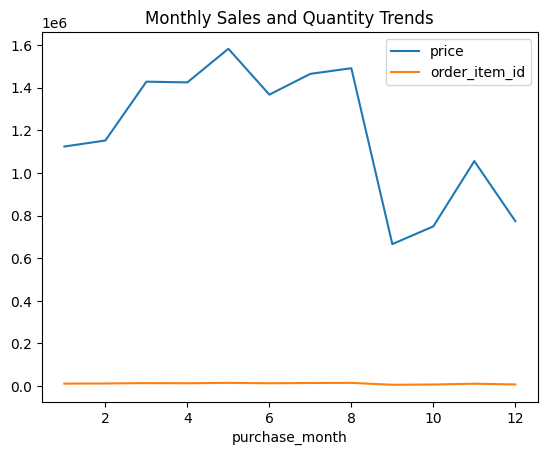

In [ ]:


Products = pd.read_csv('/content/PRODUCTS.csv')
Geo_Location = pd.read_csv('/content/GEO_LOCATION.csv')
Order_Items = pd.read_csv('/content/ORDER_ITEMS.csv')
Order_Review_Ratings = pd.read_csv('/content/ORDER_REVIEW_RATINGS.csv')
Orders = pd.read_csv('/content/ORDERS.csv')
Customers = pd.read_csv('/content/CUSTOMERS.csv')
Sellers = pd.read_csv('/content/SELLERS.csv')
Order_Payments = pd.read_csv('/content/ORDER_PAYMENTS.csv')


Orders['order_purchase_timestamp'] = pd.to_datetime(Orders['order_purchase_timestamp'], errors='coerce')
Orders['order_approved_at'] = pd.to_datetime(Orders['order_approved_at'], errors='coerce')
Orders['order_delivered_carrier_date'] = pd.to_datetime(Orders['order_delivered_carrier_date'], errors='coerce')
Orders['order_delivered_customer_date'] = pd.to_datetime(Orders['order_delivered_customer_date'], errors='coerce')
Orders['order_estimated_delivery_date'] = pd.to_datetime(Orders['order_estimated_delivery_date'], errors='coerce')

Order_Review_Ratings['review_creation_date'] = pd.to_datetime(Order_Review_Ratings['review_creation_date'], errors='coerce')
Order_Review_Ratings['review_answer_timestamp'] = pd.to_datetime(Order_Review_Ratings['review_answer_timestamp'], errors='coerce')

Order_Items['shipping_limit_date'] = pd.to_datetime(Order_Items['shipping_limit_date'], errors='coerce')


merged_data = (
    Orders.merge(Customers, on='customer_id', how='left')
          .merge(Order_Items, on='order_id', how='left')
          .merge(Order_Payments, on='order_id', how='left')
          .merge(Order_Review_Ratings, on='order_id', how='left')
          .merge(Sellers, on='seller_id', how='left')
          .merge(Products, on='product_id', how='left')
          .merge(Geo_Location, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')
)


merged_data['purchase_month'] = merged_data['order_purchase_timestamp'].dt.month
merged_data['purchase_week'] = merged_data['order_purchase_timestamp'].dt.isocalendar().week
merged_data['purchase_day'] = merged_data['order_purchase_timestamp'].dt.day
merged_data['purchase_time'] = merged_data['order_purchase_timestamp'].dt.hour
merged_data['payment_method'] = merged_data['payment_type']

total_revenue = merged_data['price'].sum()
total_quantity = merged_data['order_item_id'].sum()
total_products = merged_data['product_id'].nunique()
total_categories = merged_data['product_category_name'].nunique()
total_sellers = merged_data['seller_id'].nunique()
total_locations = merged_data['customer_city'].nunique()
total_channels = merged_data['payment_type'].nunique()
total_payment_methods = merged_data['payment_type'].nunique()

print(f"Total Revenue: {total_revenue}")
print(f"Total Quantity: {total_quantity}")
print(f"Total Products: {total_products}")
print(f"Total Categories: {total_categories}")
print(f"Total Sellers: {total_sellers}")
print(f"Total Locations: {total_locations}")
print(f"Total Channels: {total_channels}")
print(f"Total Payment Methods: {total_payment_methods}")


first_purchase = Orders.groupby('customer_id')['order_purchase_timestamp'].min().reset_index()
first_purchase['first_purchase_month'] = first_purchase['order_purchase_timestamp'].dt.to_period('M')
new_customers = first_purchase['first_purchase_month'].value_counts().sort_index().reset_index()
new_customers.columns = ['Month', 'New Customers']
print(new_customers)


last_purchase = Orders.groupby('customer_id')['order_purchase_timestamp'].max().reset_index()
last_purchase['last_purchase_month'] = last_purchase['order_purchase_timestamp'].dt.to_period('M')
customer_lifetime = pd.merge(first_purchase, last_purchase, on='customer_id')
customer_acquisition = customer_lifetime['first_purchase_month'].value_counts().sort_index().reset_index()
customer_acquisition.columns = ['Month', 'Acquired Customers']
retained_customers = customer_lifetime.groupby('last_purchase_month').size().reset_index()
retained_customers.columns = ['Month', 'Retained Customers']
customer_retention = pd.merge(customer_acquisition, retained_customers, on='Month', how='left')
customer_retention['Retention Rate'] = (customer_retention['Retained Customers'] / customer_retention['Acquired Customers']) * 100
print(customer_retention)


merged_data['is_new_customer'] = merged_data.groupby('customer_id')['order_purchase_timestamp'].rank(method='first') == 1
existing_customers_revenue = merged_data[~merged_data['is_new_customer']].groupby('purchase_month')['price'].sum()
new_customers_revenue = merged_data[merged_data['is_new_customer']].groupby('purchase_month')['price'].sum()
revenues_data = pd.DataFrame({'Existing Customers Revenue': existing_customers_revenue, 'New Customers Revenue': new_customers_revenue})
print(revenues_data)


category_sales_quantity = merged_data.groupby('product_category_name')[['price', 'order_item_id']].sum()
location_sales_quantity = merged_data.groupby('geolocation_city')[['price', 'order_item_id']].sum()
time_sales_quantity = merged_data.groupby('purchase_time')[['price', 'order_item_id']].sum()

print("Category Sales and Quantity:")
print(category_sales_quantity.head())
print("\nLocation Sales and Quantity:")
print(location_sales_quantity.head())
print("\nTime Sales and Quantity:")
print(time_sales_quantity.head())


popular_products_by_month = merged_data.groupby(['purchase_month', 'product_id', 'product_category_name'])['order_item_id'].count().reset_index()
popular_products_by_seller = merged_data.groupby(['seller_id', 'product_id', 'product_category_name'])['order_item_id'].count().reset_index()
popular_products_by_state = merged_data.groupby(['geolocation_state', 'product_id', 'product_category_name'])['order_item_id'].count().reset_index()
popular_products_by_category = merged_data.groupby(['product_category_name', 'product_id'])['order_item_id'].count().reset_index()

print("Popular Products by Month:")
print(popular_products_by_month.head())
print("\nPopular Products by Seller:")
print(popular_products_by_seller.head())
print("\nPopular Products by State:")
print(popular_products_by_state.head())
print("\nPopular Products by Category:")
print(popular_products_by_category.head())


merged_data['total_revenue'] = merged_data['price'] + merged_data['freight_value']
customer_revenue = merged_data.groupby('customer_id')['total_revenue'].sum().reset_index()
seller_revenue = merged_data.groupby('seller_id')['total_revenue'].sum().reset_index()

revenue_bins = [0, 100, 500, 1000, float('inf')]
revenue_labels = ['Low', 'Medium', 'High', 'Very High']
customer_revenue['revenue_group'] = pd.cut(customer_revenue['total_revenue'], bins=revenue_bins, labels=revenue_labels)
seller_revenue['revenue_group'] = pd.cut(seller_revenue['total_revenue'], bins=revenue_bins, labels=revenue_labels)

print("Customer Revenue Groups:")
print(customer_revenue.head())
print("\nSeller Revenue Groups:")
print(seller_revenue.head())


payment_behavior = Order_Payments['payment_type'].value_counts(normalize=True) * 100
print("Payment Behavior - Percentage of Payment Methods:")
print(payment_behavior)


category_ratings = merged_data.groupby('product_category_name')['review_score'].mean().reset_index()
top_10_max_rated = category_ratings.sort_values('review_score', ascending=False).head(10)
top_10_min_rated = category_ratings.sort_values('review_score').head(10)

print("Top 10 Maximum Rated Categories:")
print(top_10_max_rated)
print("\nTop 10 Minimum Rated Categories:")
print(top_10_min_rated)


plt.figure(figsize=(12, 6))
monthly_sales_quantity = merged_data.groupby('purchase_month')[['price', 'order_item_id']].sum()
monthly_sales_quantity.plot(kind='line')
plt.title('Monthly Sales and Quantity Trends')
plt.show()


### 1. Overview and Basic Metrics
#### Total Revenue: Calculate and visualize the total revenue.
#### Total Orders: Determine the total number of orders.
#### Customer Demographics: Analyze the distribution of customers across various regions.
#### Top 10 Cities by Sales: Identify and visualize the top cities contributing to revenue

In [ ]:
import plotly.express as px


total_revenue = merged_data['price'].sum()
print(f"Total Revenue: ${total_revenue:,.2f}")


top_cities = merged_data.groupby('geolocation_city')['price'].sum().sort_values(ascending=False).head(10).reset_index()
fig = px.bar(top_cities, x='geolocation_city', y='price', title='Top 10 Cities by Sales')
fig.show()


Total Revenue: $14,274,961.23


### 2. Customer Acquisition and Retention
#### New vs. Returning Customers: Compare the behavior and revenue contribution of new vs. returning customers.
#### Monthly New Customers: Track how many new customers are acquired each month.



In [ ]:
fig = px.histogram(merged_data, x='is_new_customer', y='price', title='Revenue Contribution: New vs Returning Customers')
fig.show()
new_customers['Month'] = new_customers['Month'].astype(str)
fig = px.line(new_customers, x='Month', y='New Customers', title='New Customers Acquired Each Month')
fig.show()


### 3. Sales Analysis
#### Sales Trends Over Time: Analyze monthly, weekly, and daily sales trends.
#### Sales by Product Category: Determine which product categories drive the most revenue.
#### Seasonality Analysis: Identify seasonal peaks in sales.

In [ ]:

monthly_sales = merged_data.groupby('purchase_month')['price'].sum().reset_index()
fig = px.line(monthly_sales, x='purchase_month', y='price', title='Monthly Sales Trends')
fig.show()

category_sales = merged_data.groupby('product_category_name')['price'].sum().reset_index()
fig = px.bar(category_sales, x='product_category_name', y='price', title='Sales by Product Category')
fig.show()

merged_data['weekday'] = merged_data['order_purchase_timestamp'].dt.day_name()
weekday_sales = merged_data.groupby('weekday')['price'].sum().reset_index()
fig = px.bar(weekday_sales, x='weekday', y='price', title='Sales by Day of the Week')
fig.show()


### 4. Product and Seller Insights
#### Top Selling Products: Identify top-selling products.
#### Seller Performance: Evaluate which sellers generate the most revenue.
#### Cross-Selling Opportunities: Analyze which products are often bought together.

In [ ]:

top_products = merged_data.groupby('product_id')['price'].sum().sort_values(ascending=False).head(10).reset_index()
fig = px.bar(top_products, x='product_id', y='price', title='Top 10 Selling Products')
fig.show()


top_sellers = merged_data.groupby('seller_id')['price'].sum().sort_values(ascending=False).head(10).reset_index()
fig = px.bar(top_sellers, x='seller_id', y='price', title='Top 10 Sellers by Revenue')
fig.show()


from itertools import combinations
from collections import Counter


order_groups = merged_data.groupby('order_id')['product_id'].apply(list)


product_combinations = Counter()

for order_products in order_groups:

    if len(order_products) > 1:

        combinations_list = list(combinations(order_products, 2))


        product_combinations.update(combinations_list)

top_10_cross_selling = product_combinations.most_common(10)

df_cross_selling = pd.DataFrame(top_10_cross_selling, columns=['Product Pair', 'Count'])

df_cross_selling[['Product 1', 'Product 2']] = pd.DataFrame(df_cross_selling['Product Pair'].tolist(), index=df_cross_selling.index)

fig = px.bar(df_cross_selling, x='Product 1', y='Count', color='Product 2', title='Top 10 Cross-Selling Product Pairs')
fig.show()



### 5. Customer Satisfaction Analysis
#### Average Ratings by Product Category: Bar chart showing average ratings by product category.
#### Customer Feedback by Location: Bar chart showing average ratings by location.
#### Rating Distribution: Histogram showing the distribution of customer ratings.

In [ ]:

fig = px.bar(category_ratings, x='product_category_name', y='review_score', title='Average Ratings by Product Category')
fig.show()


location_ratings = merged_data.groupby('geolocation_city')['review_score'].mean().reset_index()
fig = px.bar(location_ratings, x='geolocation_city', y='review_score', title='Average Ratings by Location')
fig.show()

fig = px.histogram(merged_data, x='review_score', title='Distribution of Customer Ratings')
fig.show()


### 6. Payment Behavior
#### Payment Method Preferences: Pie chart showing the distribution of payment methods.


In [ ]:

payment_behavior = Order_Payments['payment_type'].value_counts(normalize=True).reset_index()
payment_behavior.columns = ['payment_type', 'proportion']

fig = px.pie(payment_behavior, values='proportion', names='payment_type', title='Payment Method Preferences')
fig.show()



### 7. Customer Segmentation via Clustering
#### Customer Segments: Scatter plot showing customer segments based on spending, order frequency, and average order value. With removing outlier (highest and lowest 1 %)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import plotly.express as px


customer_features = merged_data.groupby('customer_id').agg({
    'price': 'sum',
    'order_id': 'count',
    'freight_value': 'mean'
}).reset_index()


customer_features.columns = ['customer_id', 'total_spent', 'num_orders', 'avg_freight']


customer_features['total_spent'].fillna(customer_features['total_spent'].mean(), inplace=True)
customer_features['num_orders'].fillna(customer_features['num_orders'].mean(), inplace=True)
customer_features['avg_freight'].fillna(customer_features['avg_freight'].mean(), inplace=True)

spent_threshold = customer_features['total_spent'].quantile(0.99)  # 99th percentile
orders_threshold = customer_features['num_orders'].quantile(0.99)  # 99th percentile

customer_features_filtered = customer_features[
    (customer_features['total_spent'] <= spent_threshold) &
    (customer_features['num_orders'] <= orders_threshold)
]

scaler = StandardScaler()
customer_features_scaled = scaler.fit_transform(customer_features_filtered[['total_spent', 'num_orders', 'avg_freight']])


kmeans = KMeans(n_clusters=4, random_state=42)
customer_features_filtered['cluster'] = kmeans.fit_predict(customer_features_scaled)


import plotly.express as px


fig = px.scatter_3d(
    customer_features_filtered,
    x='total_spent',
    y='num_orders',
    z='avg_freight',
    color='cluster',
    title='Customer Segments After Outlier Removal in 3D',
    labels={
        'total_spent': 'Total Spent (in $)',
        'num_orders': 'Number of Orders',
        'avg_freight': 'Average Freight Cost'
    },
    color_continuous_scale=px.colors.sequential.Plasma,
    size_max=10
)

fig.update_traces(marker=dict(size=5, line=dict(width=1, color='DarkSlateGrey')))
fig.update_layout(
    scene = dict(
        xaxis_title='Total Spent (in $)',
        yaxis_title='Number of Orders',
        zaxis_title='Average Freight Cost'
    ),
    title_font_size=18,
    scene_aspectmode='cube',
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)'
)

fig.show()



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

<ipython-input-10-b8f42427764c>:38: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### 8. Product Segmentation via Clustering
#### Product Segments: Scatter plot showing product segments based on sales, average price, and review scores.

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import plotly.express as px


product_features = merged_data.groupby('product_id').agg({
    'price': 'sum',
    'review_score': 'mean',
    'order_item_id': 'count'
}).reset_index()
product_features.columns = ['product_id', 'total_sales', 'avg_review', 'num_orders']


q1 = product_features['total_sales'].quantile(0.05)
q3 = product_features['total_sales'].quantile(0.95)
iqr = q3 - q1
product_features = product_features[(product_features['total_sales'] >= (q1 - 1.5 * iqr)) &
                                    (product_features['total_sales'] <= (q3 + 1.5 * iqr))]

scaler = StandardScaler()
product_features_scaled = scaler.fit_transform(product_features[['total_sales', 'avg_review', 'num_orders']])

kmeans = KMeans(n_clusters=4, random_state=42)
product_features['cluster'] = kmeans.fit_predict(product_features_scaled)

fig = px.scatter(product_features, x='total_sales', y='num_orders', color='cluster',
                 title='Product Segments After Outlier Removal and Scaling')
fig.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



### 9. Recommendation System
#### Displaying different ways we can use recommendation systems

#####  recommend products by location with visualization

<ipython-input-12-8ddf24b6f5b5>:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




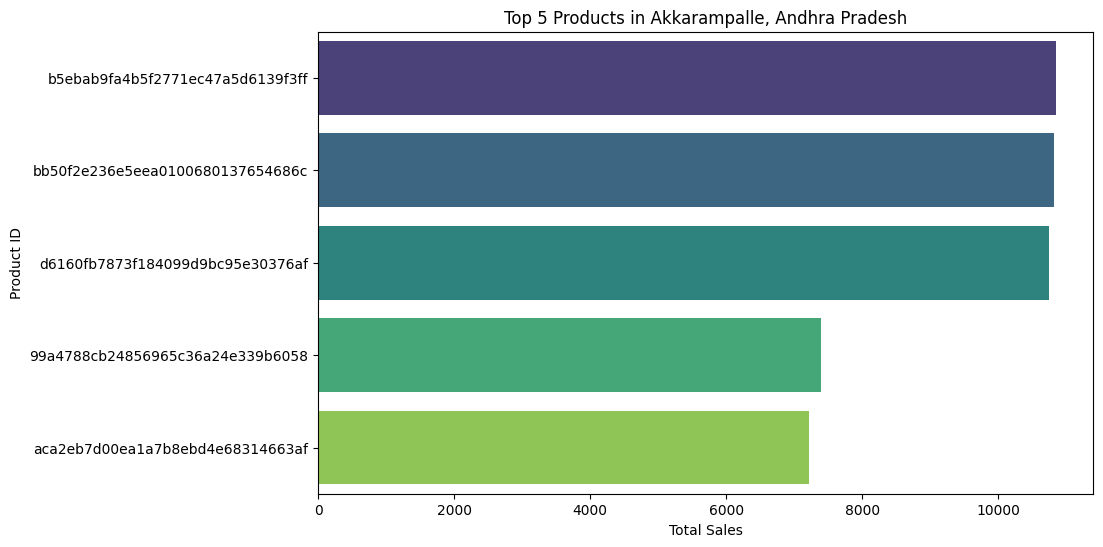

Recommended Products for Akkarampalle, Andhra Pradesh: ['b5ebab9fa4b5f2771ec47a5d6139f3ff', 'bb50f2e236e5eea0100680137654686c', 'd6160fb7873f184099d9bc95e30376af', '99a4788cb24856965c36a24e339b6058', 'aca2eb7d00ea1a7b8ebd4e68314663af']


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


def recommend_products_by_location(city, state, n_recommendations=5):

    location_data = merged_data[(merged_data['customer_city'] == city) &
                                (merged_data['customer_state'] == state)]


    top_products = location_data.groupby('product_id')['price'].sum().sort_values(ascending=False).head(n_recommendations)


    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_products.values, y=top_products.index, palette="viridis")
    plt.title(f"Top {n_recommendations} Products in {city}, {state}")
    plt.xlabel('Total Sales')
    plt.ylabel('Product ID')
    plt.show()


    return top_products.index.tolist()

recommended_products = recommend_products_by_location(city='Akkarampalle', state='Andhra Pradesh')
print("Recommended Products for Akkarampalle, Andhra Pradesh:", recommended_products)


##### Product Recommendation by Payment Method

<ipython-input-13-5b58007b973c>:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




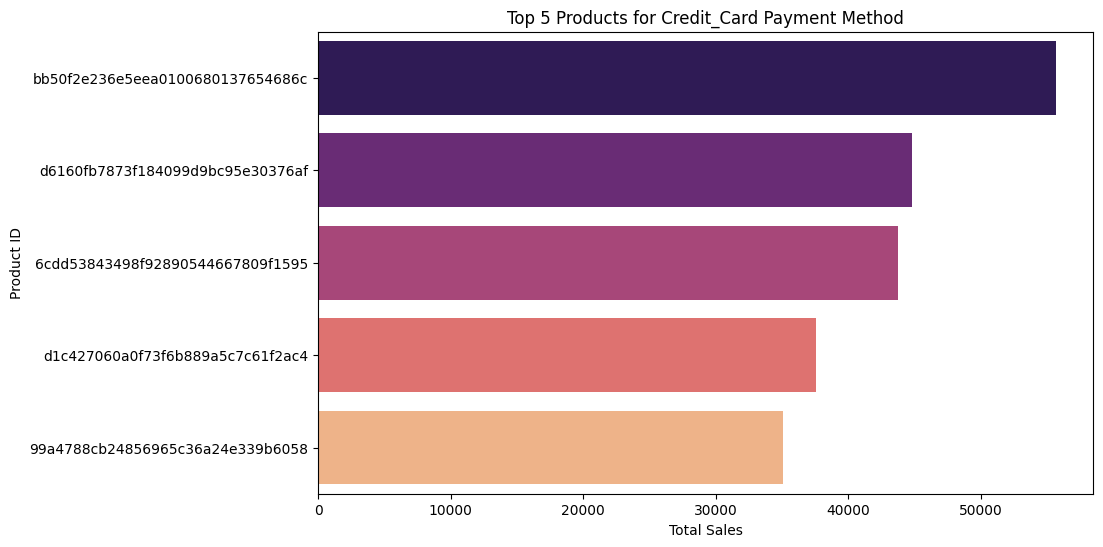

Recommended Products for Credit Card Users: ['bb50f2e236e5eea0100680137654686c', 'd6160fb7873f184099d9bc95e30376af', '6cdd53843498f92890544667809f1595', 'd1c427060a0f73f6b889a5c7c61f2ac4', '99a4788cb24856965c36a24e339b6058']


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def recommend_products_by_payment(payment_type, n_recommendations=5):
    payment_data = merged_data[merged_data['payment_type'] == payment_type]
    top_products = payment_data.groupby('product_id')['price'].sum().sort_values(ascending=False).head(n_recommendations)


    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_products.values, y=top_products.index, palette="magma")
    plt.title(f"Top {n_recommendations} Products for {payment_type.title()} Payment Method")
    plt.xlabel('Total Sales')
    plt.ylabel('Product ID')
    plt.show()

    return top_products.index.tolist()

recommended_products = recommend_products_by_payment(payment_type='credit_card')
print("Recommended Products for Credit Card Users:", recommended_products)


##### Product Recommendation by Purchase History


In [ ]:
!pip install faiss-cpu


                           order_id  random_order_id
0  e481f51cbdc54678b7cc49136f2d6af7             7942
1  e481f51cbdc54678b7cc49136f2d6af7            20200
2  e481f51cbdc54678b7cc49136f2d6af7             7887
3  53cdb2fc8bc7dce0b6741e2150273451             3385
4  47770eb9100c2d0c44946d9cf07ec65d             1925


<ipython-input-22-59de243895e7>:57: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




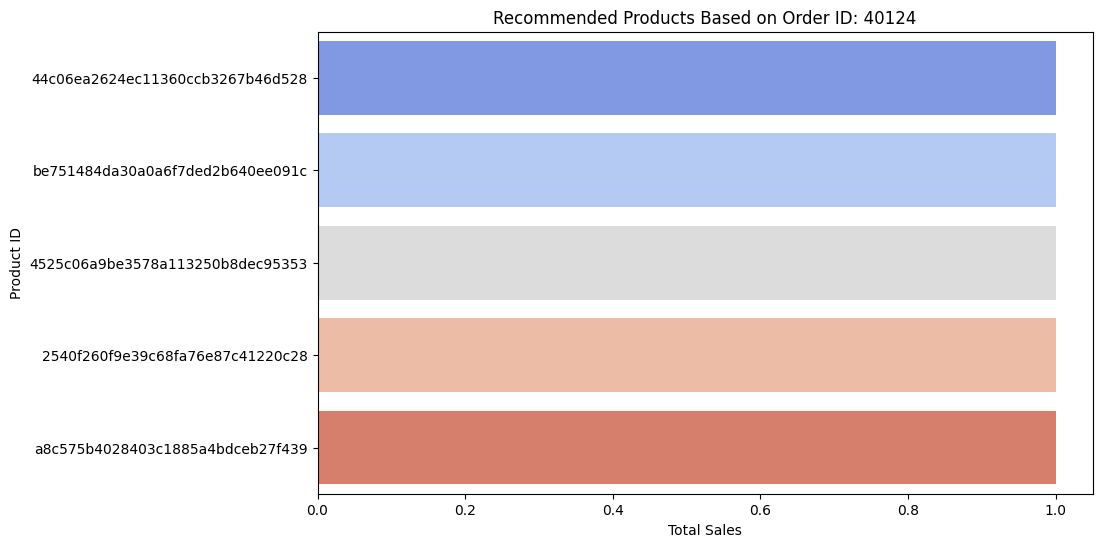

Recommended Products Based on Random Order ID 40124: ['44c06ea2624ec11360ccb3267b46d528', 'be751484da30a0a6f7ded2b640ee091c', '4525c06a9be3578a113250b8dec95353', '2540f260f9e39c68fa76e87c41220c28', 'a8c575b4028403c1885a4bdceb27f439']


In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
import faiss
import matplotlib.pyplot as plt
import seaborn as sns

merged_data = merged_data.dropna(subset=['product_id', 'order_id', 'price'])


rows = merged_data['product_id'].astype('category').cat.codes
cols = merged_data['random_order_id'].astype('category').cat.codes
data = merged_data['price']

product_order_sparse = csr_matrix((data, (rows, cols)))

svd = TruncatedSVD(n_components=50, random_state=42)
product_order_reduced = svd.fit_transform(product_order_sparse)

product_order_reduced = product_order_reduced.astype('float32')

index = faiss.IndexFlatL2(product_order_reduced.shape[1])
index.add(product_order_reduced)

def recommend_products_by_history_faiss(order_id, n_recommendations=5):

    if order_id not in merged_data['random_order_id'].values:
        print(f"Order ID {order_id} does not exist in the dataset.")
        return []


    order_code = merged_data['random_order_id'].astype('category').cat.codes[merged_data['random_order_id'] == order_id]


    if order_code.empty:
        print(f"Order ID {order_id} could not be encoded.")
        return []

    order_code = order_code.iloc[0]


    similar_orders = index.search(np.array([product_order_reduced[order_code]]), n_recommendations)[1].flatten()


    recommended_products = pd.Series(similar_orders).apply(lambda x: merged_data['product_id'].astype('category').cat.categories[x])


    top_products = recommended_products.value_counts().head(n_recommendations)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_products.values, y=top_products.index, palette="coolwarm")
    plt.title(f"Recommended Products Based on Order ID: {order_id}")
    plt.xlabel('Total Sales')
    plt.ylabel('Product ID')
    plt.show()

    return recommended_products.tolist()

num_orders = merged_data.shape[0]
merged_data['random_order_id'] = np.random.randint(1, num_orders + 1, size=num_orders)


random_order_groups = np.random.randint(1, num_orders // 10, size=num_orders)
merged_data['random_order_id'] = merged_data.groupby(random_order_groups)['random_order_id'].transform(lambda x: x.min())

print(merged_data[['order_id', 'random_order_id']].head())

some_random_order_id = merged_data['random_order_id'].sample(1).iloc[0]
recommended_products = recommend_products_by_history_faiss(order_id=some_random_order_id)
print(f"Recommended Products Based on Random Order ID {some_random_order_id}:", recommended_products)


##### Recommendation for New Customers

<ipython-input-16-0613b84d7413>:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




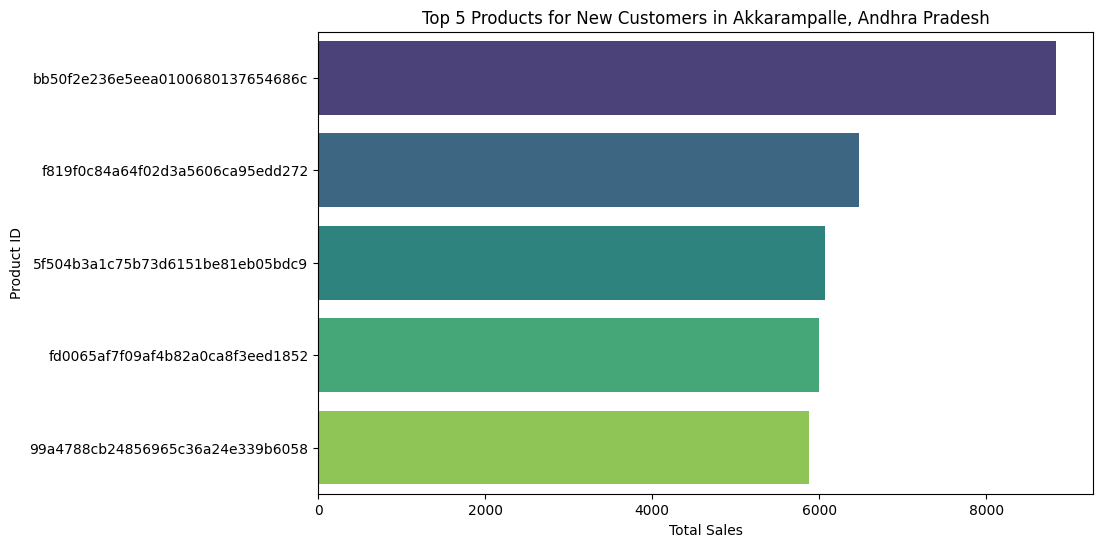

Recommended Products for New Customers in Akkarampalle, Andhra Pradesh: ['bb50f2e236e5eea0100680137654686c', 'f819f0c84a64f02d3a5606ca95edd272', '5f504b3a1c75b73d6151be81eb05bdc9', 'fd0065af7f09af4b82a0ca8f3eed1852', '99a4788cb24856965c36a24e339b6058']


In [ ]:
def recommend_products_for_new_customers(city, state, n_recommendations=5):
    location_data = merged_data[(merged_data['customer_city'] == city) &
                                (merged_data['customer_state'] == state) &
                                (merged_data['is_new_customer'] == True)]
    top_products = location_data.groupby('product_id')['price'].sum().sort_values(ascending=False).head(n_recommendations)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_products.values, y=top_products.index, palette="viridis")
    plt.title(f"Top {n_recommendations} Products for New Customers in {city}, {state}")
    plt.xlabel('Total Sales')
    plt.ylabel('Product ID')
    plt.show()

    return top_products.index.tolist()

recommended_products = recommend_products_for_new_customers(city='Akkarampalle', state='Andhra Pradesh')
print("Recommended Products for New Customers in Akkarampalle, Andhra Pradesh:", recommended_products)
